In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.optimizers.experimental import Nadam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input, Dropout, MaxPool1D, ReLU, concatenate, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
import os
import seaborn as sn

try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  colab_prefix = 'drive/MyDrive/CSE572 Project/code/'
except:
  colab_prefix = ''

model_path = colab_prefix + "models/"

Mounted at /content/drive


In [ ]:
# Load train/test data
X = pd.read_csv(colab_prefix + 'data/mitbih_train.csv', header=None)
test_X = pd.read_csv(colab_prefix + 'data/mitbih_test.csv', header=None)

In [ ]:
# create partially balanced dataset for deep residual network
residual_x = X.groupby(X.columns[187]).head(4000)
residual_x.append(X.loc[X[187] == 0.0].tail(6000))
residual_Y = to_categorical(residual_x.pop(187))

<ipython-input-3-e8c332ce1452>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  residual_x.append(X.loc[X[187] == 0.0].tail(6000))


In [ ]:
train_value_counts = X[187].value_counts().sort_index()
test_value_counts = test_X[187].value_counts().sort_index()

print(f"Class Distribution for Training Data\n{train_value_counts}\n")
print(f"Class Distribution for Testing Data\n{test_value_counts}\n")

Class Distribution for Training Data
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: 187, dtype: int64

Class Distribution for Testing Data
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
Name: 187, dtype: int64



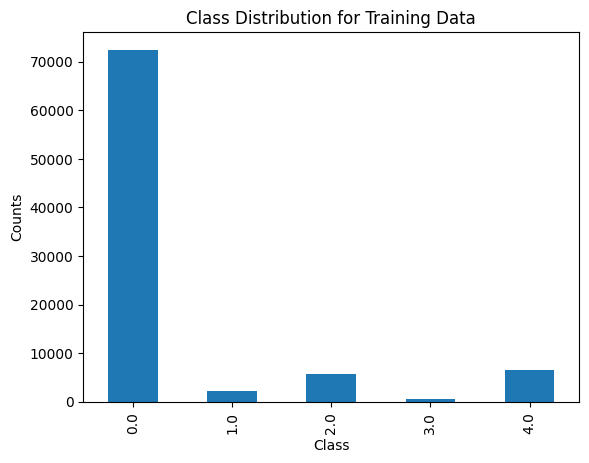

In [ ]:
fig = train_value_counts.plot(title='Class Distribution for Training Data', kind='bar', xlabel='Class', ylabel='Counts').get_figure()
fig.savefig(colab_prefix + 'img/data/train_data_distribution.png')

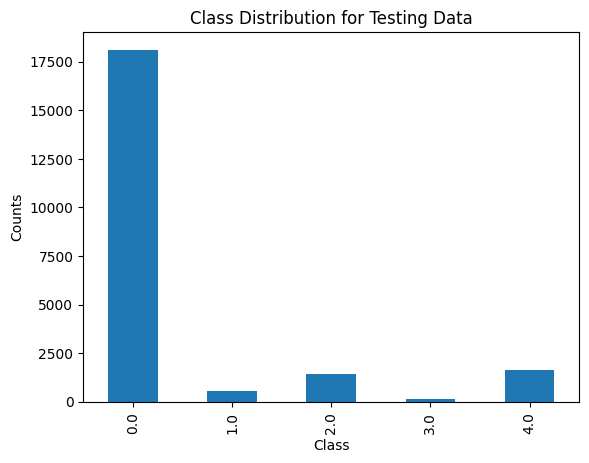

In [ ]:
fig = test_value_counts.plot(title='Class Distribution for Testing Data', kind='bar', xlabel='Class', ylabel='Counts').get_figure()
fig.savefig(colab_prefix + 'img/data/test_data_distribution.png')

In [ ]:
# separate labels from the data
labels = X.pop(187)
Y = to_categorical(labels)
test_Y = to_categorical(test_X.pop(187))

In [ ]:
# compute weights for classes to help compute weighted loss for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights[0] = class_weights[0] + 0.5

weight_dict = {0: class_weights[0] + 0.5,
               1: class_weights[1],
               2: class_weights[2],
               3: class_weights[3],
               4: class_weights[4]}

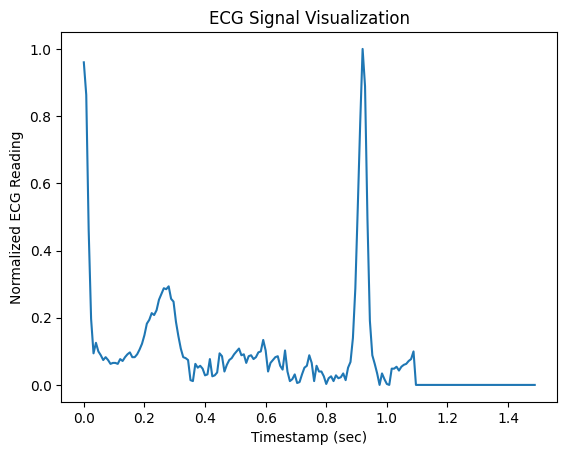

In [ ]:
# Visualize a single heartbeat
# TODO: Visualize 1 beat from all 5 classes
plt.plot(np.arange(0, 187/125, 1/125), X.iloc[1], label="Heartbeat")
plt.xlabel('Timestamp (sec)')
plt.ylabel('Normalized ECG Reading')
plt.title('ECG Signal Visualization')

plt.savefig(colab_prefix + 'img/data/' + 'signal.png', bbox_inches='tight')

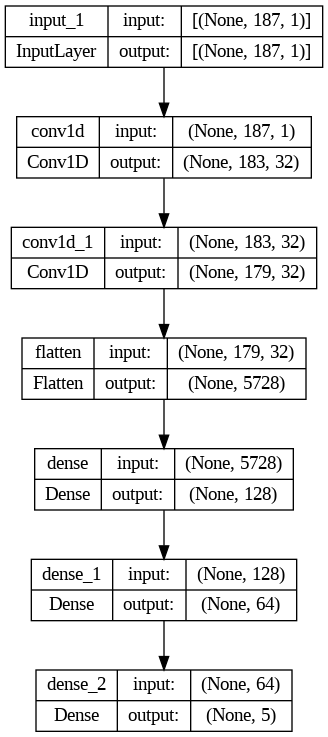

In [ ]:
# Create a simple model for testing purposes
if os.path.exists(model_path + 'base_model.keras'):
  model = load_model(model_path + 'base_model.keras', compile=False)
  model.compile(optimizer='adam',
                loss=CategoricalFocalCrossentropy(alpha=class_weights),
                metrics=['accuracy'])
else:
  model = Sequential()
  model.add(Input(shape=(187,1)))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  model.compile(optimizer='adam',
                loss=CategoricalFocalCrossentropy(alpha=class_weights),
                metrics=['accuracy'])

  model.fit(X, Y, epochs=25, batch_size=128, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])
  model.save(model_path + 'base_model.keras')

plot_model(model, to_file=colab_prefix + 'img/models/' + 'base_model.png', show_shapes=True)

In [ ]:
# calculates the accuracy, precision, recall, and F-Beta score
def calc_metrics(test_Y, predict_y):
  precision, recall, f1_score, _= precision_recall_fscore_support(np.argmax(test_Y, axis=1, out=None), np.argmax(predict_y, axis=1, out=None), average='weighted')
  accuracy = balanced_accuracy_score(np.argmax(test_Y, axis=1, out=None), np.argmax(predict_y, axis=1, out=None))
  print('Performance statistics for the model')
  print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Beta Score: {f1_score}')

In [ ]:
# function to create a normalized confusion matrix
def plot_cm(labels, predictions, name='model_cm'):
  cm = confusion_matrix(np.argmax(labels, axis=1, out=None), np.argmax(predictions, axis=1, out=None)).numpy()
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  sn.heatmap(cmn, annot=True, fmt='.2f')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(name)
  plt.savefig(colab_prefix + 'img/cm/' + name + '.png')
  plt.show()

In [ ]:
predict_y = model.predict(test_X, verbose=0)
calc_metrics(test_Y, predict_y)

Performance statistics for the model
Accuracy: 0.9196505826751199
Precision: 0.976463219035486
Recall: 0.9728211218710031
F-Beta Score: 0.9741488078688024


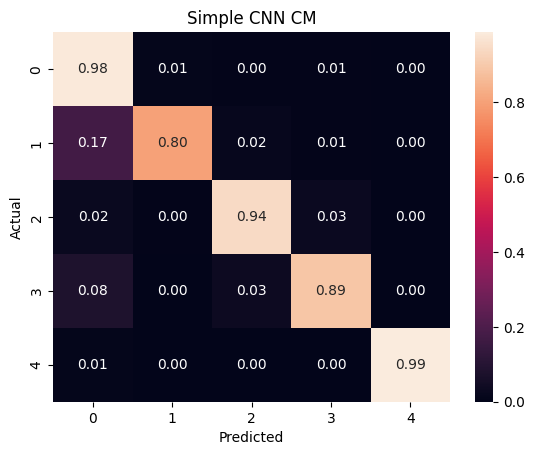

In [ ]:
plot_cm(test_Y, predict_y, 'Simple CNN CM')

In [ ]:
# Create a function for the residual block defined in https://arxiv.org/pdf/1805.00794.pdf
def residual(inputs):
    with tf.name_scope('Residual Block'):
        x = Conv1D(32, 5, activation='relu')(inputs)
        x = Conv1D(32, 5)(x)
        x = concatenate([x, inputs], axis=1)
        x = ReLU()(x)
        x = MaxPool1D(pool_size=2, strides=2)(x)
    return x


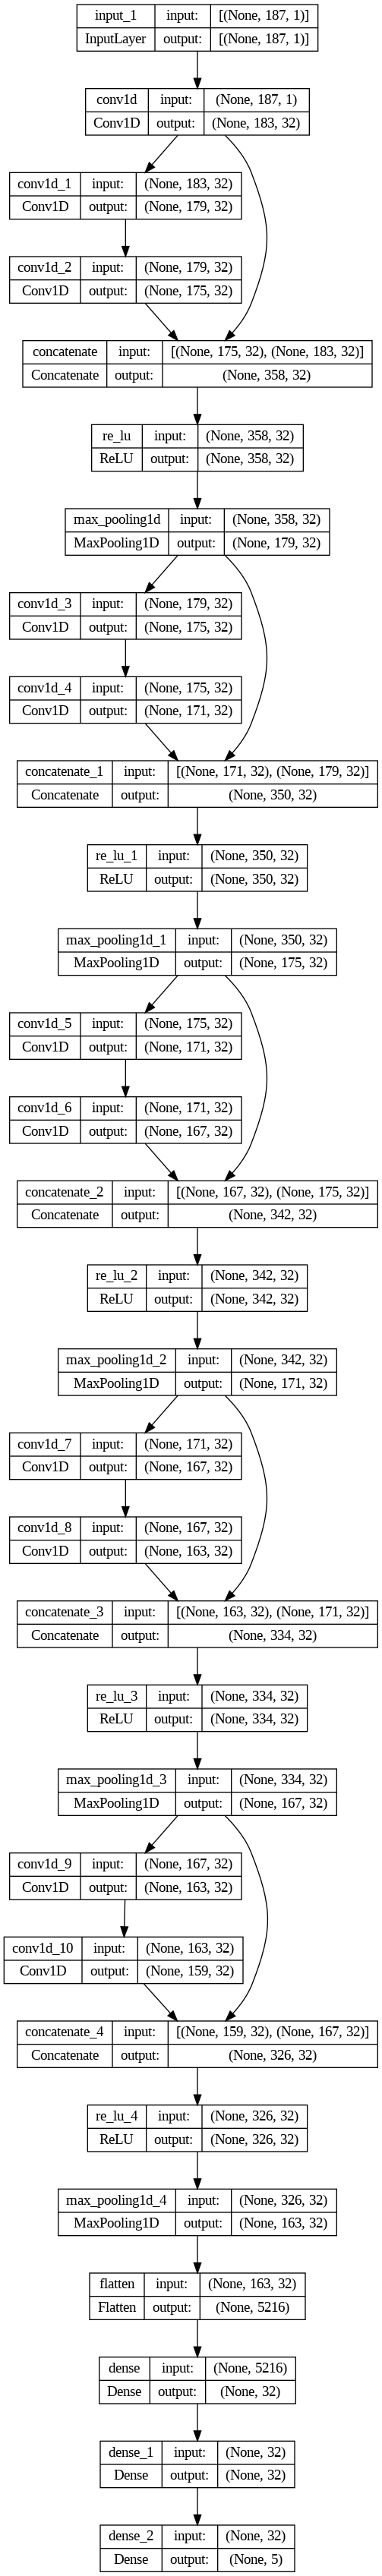

In [ ]:
# Deep residual CNN based on https://arxiv.org/pdf/1805.00794.pdf
if os.path.exists(model_path + 'residual_model.keras'):
  residual_model = load_model(model_path + 'residual_model.keras')
else:
  inp = Input(shape=(187,1))
  x = Conv1D(32, 5, activation='relu')(inp)
  x = residual(x)
  x = residual(x)
  x = residual(x)
  x = residual(x)
  x = residual(x)
  x = Flatten()(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(5, activation='softmax')(x)

  residual_model = Model(inputs=[inp], outputs=[x])

  residual_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  residual_model.fit(residual_x, residual_Y, epochs=50, batch_size=128)
  residual_model.save(model_path + 'residual_model.keras')

plot_model(residual_model, to_file=colab_prefix + 'img/models/' + 'residual.png', show_shapes=True)

In [ ]:
predict_y = residual_model.predict(test_X, verbose=0)
calc_metrics(test_Y, predict_y)

Performance statistics for the model
Accuracy: 0.9099644287568562
Precision: 0.9665892710082105
Recall: 0.9418509044399781
F-Beta Score: 0.9504142414374341


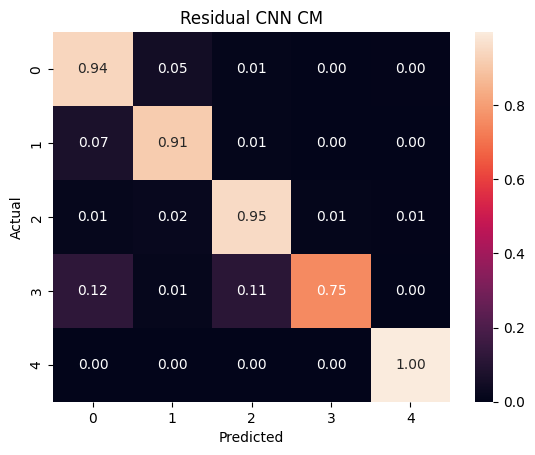

In [ ]:
plot_cm(test_Y, predict_y, 'Residual CNN CM')

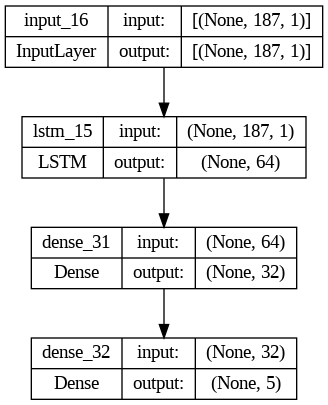

In [ ]:
# implement the simple LSTM described in https://www.hindawi.com/journals/jhe/2019/6320651/
if os.path.exists(model_path + 'simple_lstm_model.keras'):
  simple_lstm_model = load_model(model_path + 'simple_lstm_model.keras')
else:
  simple_lstm_model = tf.keras.models.Sequential()
  simple_lstm_model.add(Input(shape=(187,1)))
  simple_lstm_model.add(LSTM(64))
  simple_lstm_model.add(Dense(32, activation='relu'))
  simple_lstm_model.add(Dense(5, activation='softmax'))

  simple_lstm_model.compile(optimizer=Nadam(),
                loss=CategoricalFocalCrossentropy(),
                metrics=['accuracy'])
  simple_lstm_model.fit(X, Y, epochs=350, batch_size=128)
  simple_lstm_model.save(model_path + 'simple_lstm_model.keras')

plot_model(simple_lstm_model, to_file=colab_prefix + 'img/models/' + 'simple_lstm.png', show_shapes=True)


In [ ]:
predict_y = simple_lstm_model.predict(test_X, verbose=0)
calc_metrics(test_Y, predict_y)

Performance statistics for the model
Accuracy: 0.8983154409268741
Precision: 0.9811271918682413
Recall: 0.9813630549972593
F-Beta Score: 0.9812278343044609


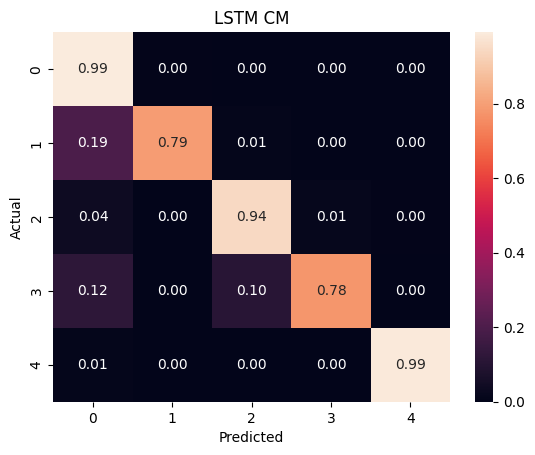

In [ ]:
plot_cm(test_Y, predict_y, 'LSTM CM')

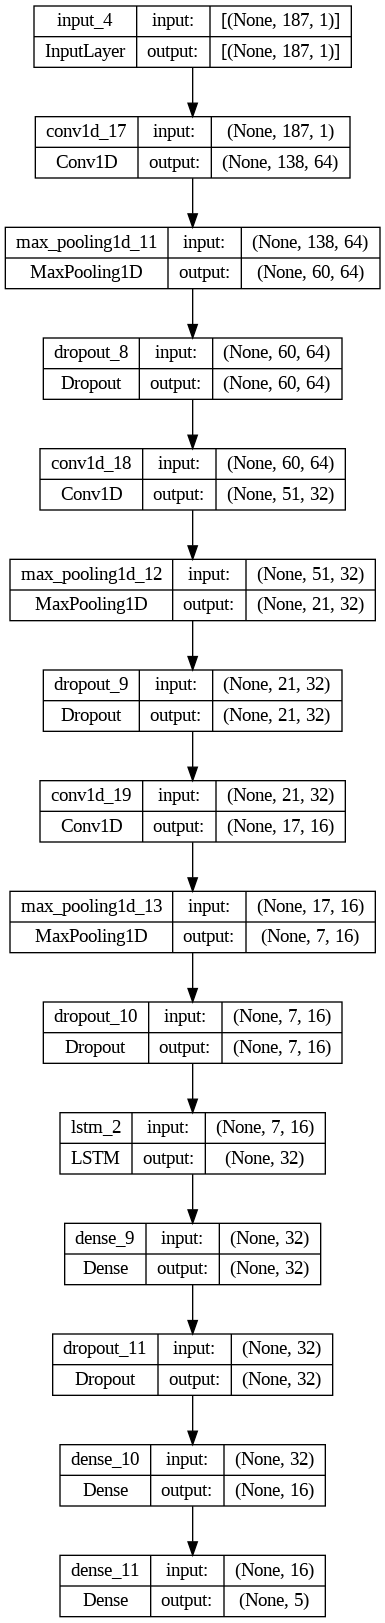

In [ ]:
# CNN LSTM model based on https://arxiv.org/pdf/2209.00988.pdf
if os.path.exists(model_path + 'hybrid_model.keras'):
  hybrid_model = load_model(model_path + 'hybrid_model.keras')
else:
  hybrid_model = Sequential()
  hybrid_model.add(Input(shape=(187,1)))
  hybrid_model.add(Conv1D(64, 50, activation='relu'))
  hybrid_model.add(MaxPool1D(pool_size=20, strides=2))
  hybrid_model.add(Dropout(0.1))
  hybrid_model.add(Conv1D(32, 10, activation='relu'))
  hybrid_model.add(MaxPool1D(pool_size=10, strides=2))
  hybrid_model.add(Dropout(0.1))
  hybrid_model.add(Conv1D(16, 5, activation='relu'))
  hybrid_model.add(MaxPool1D(pool_size=5, strides=2))
  hybrid_model.add(Dropout(0.1))
  hybrid_model.add(LSTM(32))
  hybrid_model.add(Dense(32, activation='relu'))
  hybrid_model.add(Dropout(0.1))
  hybrid_model.add(Dense(16, activation='relu'))
  hybrid_model.add(Dense(5, activation='softmax'))

  hybrid_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  hybrid_model.fit(X, Y, epochs=100, batch_size=128, class_weight=weight_dict)
  hybrid_model.save(model_path + 'hybrid_model.keras')

plot_model(hybrid_model, to_file=colab_prefix + 'img/models/' + 'hybrid_model.png', show_shapes=True)

In [ ]:
predict_y = hybrid_model.predict(test_X, verbose=0)
calc_metrics(test_Y, predict_y)

Performance statistics for the model
Accuracy: 0.909604454244264
Precision: 0.9663314540350728
Recall: 0.94961629819112
F-Beta Score: 0.9558235543829163


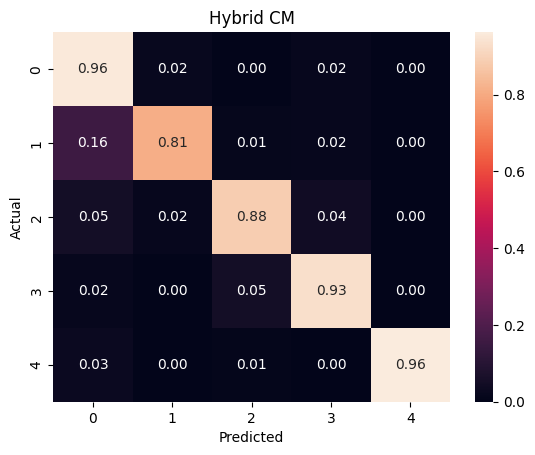

In [ ]:
plot_cm(test_Y, predict_y, 'Hybrid CM')

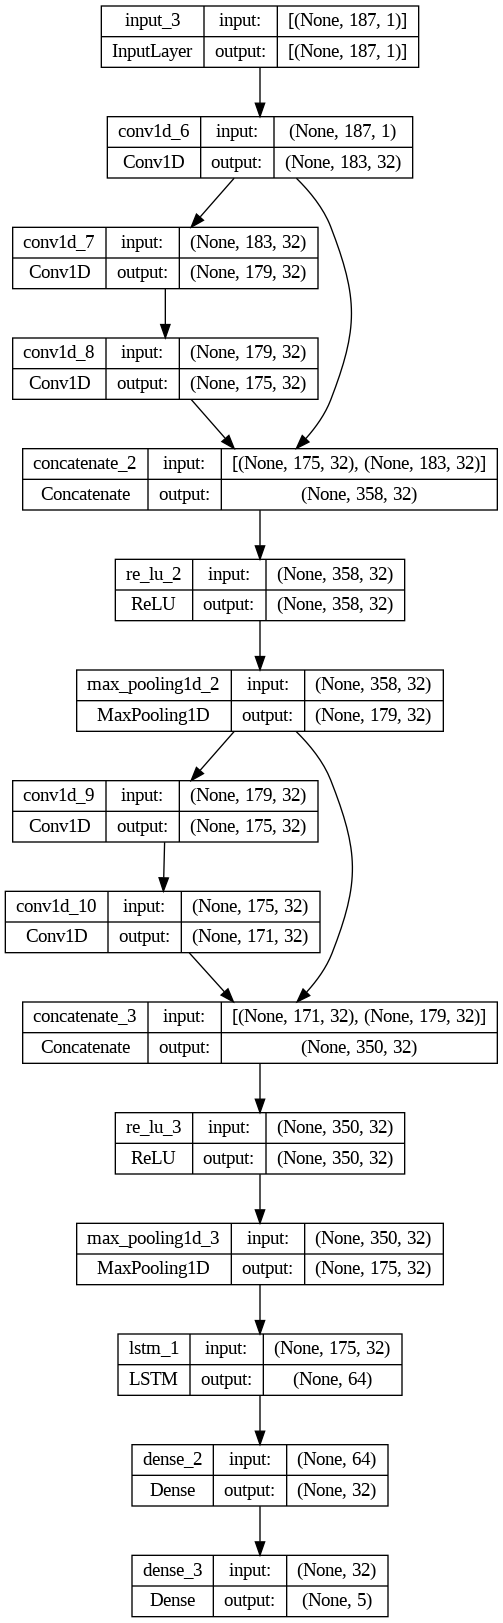

In [ ]:
# my own model using convolutions for feature extraction followed by an LSTM
if os.path.exists(model_path + 'my_model.keras'):
  my_model = load_model(model_path + 'my_model.keras', compile=False)
  model.compile(optimizer='adam',
                loss=CategoricalFocalCrossentropy(alpha=class_weights),
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
else:
  inp = Input(shape=(187,1))
  x = Conv1D(32, 5, activation='relu')(inp)
  x = residual(x)
  x = residual(x)
  x = LSTM(64)(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(5, activation='softmax')(x)

  my_model = Model(inputs=[inp], outputs=[x])

  my_model.compile(optimizer=Nadam(),
                loss=CategoricalFocalCrossentropy(alpha=class_weights),
                metrics=['accuracy'])
  my_model.fit(X, Y, epochs=350, batch_size=128)
  my_model.save(model_path + 'my_model.keras')

plot_model(my_model, to_file=colab_prefix + 'img/models/' + 'my_model.png', show_shapes=True)

In [ ]:
predict_y = my_model.predict(test_X, verbose=0)
calc_metrics(test_Y, predict_y)

Performance statistics for the model
Accuracy: 0.9282420405743631
Precision: 0.9753766878802407
Recall: 0.9701260734514892
F-Beta Score: 0.9719792420843688


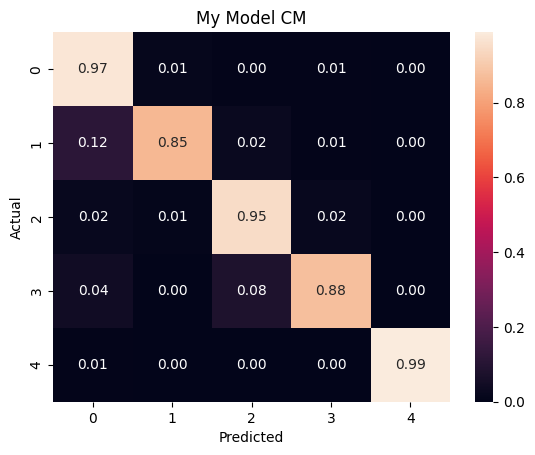

In [ ]:
plot_cm(test_Y, predict_y, 'My Model CM')